# Tutorial for TISSUE

To install TISSUE and its dependencies **in the future**:

```
pip install tissue-bio
```

We recommend doing this within a conda environment: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html



If you find this tool useful for your project, please cite:

CITATION TBD

Note that in this tutorial, we are using the SpaGE algorithm for prediction. The basic installation of TISSUE is compatible with both Harmony (kNN-based) and SpaGE and can also work with Tangram if Tangram is independently installed.

In [1]:
# import packages

import tissue.main, tissue.downstream

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import os

## Load data and metadata

Here we load a minimal subset of osmFISH spatial transcriptomics data of mouse somatosensory cortex published by Codeluppi et al., 2018: https://doi.org/10.1038/s41592-018-0175-z. 

Note that we are using the TISSUE methods for building an AnnData object from tab-delimited text files for the spatial counts, scRNAseq counts, spatial locations, and spatial metadata. If you already have an AnnData object for the spatial data and another object for the scRNAseq data, you can skip this step.

In [2]:
# load in spatial and scRNAseq datasets

adata, RNAseq_adata = tissue.main.load_paired_datasets("tests/data/Spatial_count.txt",
                                           "tests/data/Locations.txt",
                                           "tests/data/scRNA_count.txt")

/home/edsun/anaconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/test/lib/python3.8/site-packages/anndata/_core/anndata.py:856: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


## Impute missing gene expression

Now we can impute any genes of interest that are found in the scRNAseq dataset but not in the spatial dataset. In this case, we will hold out a target gene from the spatial data and apply an imputation method to predict its expression using the scRNAseq dataset.

First, we preprocess the data and make sure that the gene names are matchable across the two datasets:

In [3]:
# make genes lowercase
adata.var_names = [x.lower() for x in adata.var_names]
RNAseq_adata.var_names = [x.lower() for x in RNAseq_adata.var_names]

# preprocess RNAseq data
tissue.main.preprocess_data(RNAseq_adata, standardize=False, normalize=True)

# subset spatial data into shared genes
gene_names = np.intersect1d(adata.var_names, RNAseq_adata.var_names)
adata = adata[:, gene_names].copy()

# hold out target gene
target_gene = "plp1"
target_expn = adata[:, target_gene].X.copy()
adata = adata[:, [gene for gene in gene_names if gene != target_gene]].copy()

In [4]:
adata.shape

(3405, 31)

In [5]:
RNAseq_adata.shape

(1000, 32)

Now, we can make predictions of the target gene expression. In TISSUE, we currently have several methods for gene imputation including SpaGE, Tangram, and Harmony-kNN. We will be using SpaGE in this example:

In [6]:
# SpaGE spatial gene expression prediction

tissue.main.predict_gene_expression (adata, RNAseq_adata, [target_gene],
                                     method="spage", n_folds=10, n_pv=10)

How good is the imputation? Since we left out this gene from the spatial data, we can plot the predicted and actual expression and visually inspect the agreement.

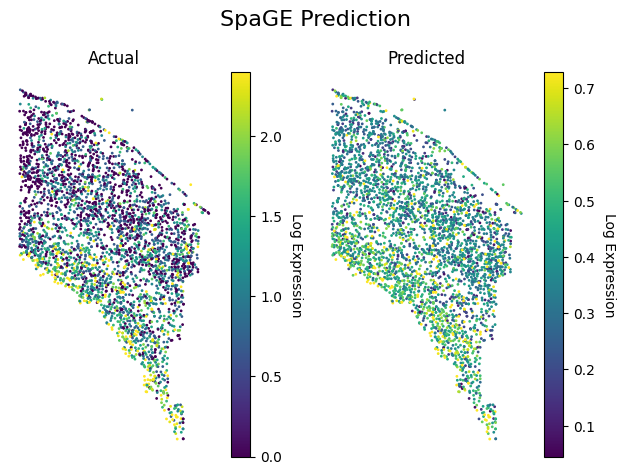

In [7]:
# Visualizing predicted and actual expression side by side

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
cmap = target_expn
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax1.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax1.set_title('Actual', fontsize = 12)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270)

ax2.axis('off')
cmap = adata.obsm['spage_predicted_expression'][target_gene].values
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax2.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax2.set_title('Predicted', fontsize = 12)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270)

plt.suptitle("SpaGE Prediction", fontsize=16)
plt.tight_layout()
plt.show()

Not too bad, especially considering that we used a downsampled scRNAseq dataset for this imputation.

## Computing TISSUE uncertainties for predicted gene expression

Note that when we ran `tissue.main.predict_gene_expression()` in the previous section, we obtained cross-validated predictions for all genes in the existing spatial dataset (e.g. 10 folds). These will now come in handy when we compute and calibrate TISSUE uncertainties for the predicted gene expression.

First, we build spatial graphs using TISSUE (this can also be done with native Scanpy functions):

In [8]:
# build spatial graph and calculate adjacency weights

tissue.main.build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)

The entire TISSUE spatial uncertainty generation pipeline can be launched with one line of code using `tissue.main.conformalize_spatial_uncertainty()`. Here, the first two arguments are the spatial AnnData object and a string specifier for the key in `obsm` corresponding to the predicted gene expression. We can specify which of the genes to use in the calibration set (generally this is all genes in the spatial data). There are other arguments for the grouping setup and weighting schemes, but we will use the default settings in this tutorial.

In [9]:
# build calibration scores

tissue.main.conformalize_spatial_uncertainty(adata, "spage_predicted_expression", calib_genes=adata.var_names)

In [10]:
adata

AnnData object with n_obs × n_vars = 3405 × 31
    uns: 'conf_genes_used', 'target_genes_used', 'spatial_neighbors'
    obsm: 'spatial', 'spage_predicted_expression', 'spage_predicted_expression_uncertainty', 'spage_predicted_expression_score', 'spage_predicted_expression_error', 'spage_predicted_expression_groups'
    obsp: 'spatial_connectivities', 'spatial_distances'

Finally, we can calibrate the spatial uncertainty measures to get calibration scores and then use those to extract prediction intervals for any confidence level $1-\alpha$. This is done with `tissue.main.conformalize_prediction_interval()`

In [11]:
# get prediction interval for 67% coverage

tissue.main.conformalize_prediction_interval (adata, "spage_predicted_expression", calib_genes=adata.var_names,
                                              alpha_level=0.33)

In [12]:
adata

AnnData object with n_obs × n_vars = 3405 × 31
    uns: 'conf_genes_used', 'target_genes_used', 'spatial_neighbors', 'alpha'
    obsm: 'spatial', 'spage_predicted_expression', 'spage_predicted_expression_uncertainty', 'spage_predicted_expression_score', 'spage_predicted_expression_error', 'spage_predicted_expression_groups', 'spage_predicted_expression_lo', 'spage_predicted_expression_hi'
    obsp: 'spatial_connectivities', 'spatial_distances'

Now let's visualize what these prediction intervals look like for the target (unseen) gene and how it compares to the actual prediction errors.

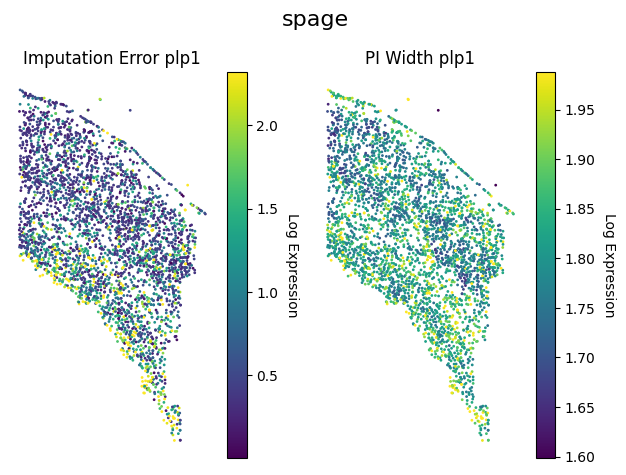

In [13]:
m = "spage"

i = np.where(adata.var_names == target_gene)[0]

# define consistent color map
all_vals = np.concatenate((np.abs(target_expn.flatten()-adata.obsm[m+"_predicted_expression"][target_gene].values),
                           adata.obsm[m+f"_predicted_expression_hi"][target_gene].values-adata.obsm[m+f"_predicted_expression_lo"][target_gene].values))
all_vals[all_vals<0]=0
vmin = np.percentile(np.log1p(all_vals), 0)
vmax = np.percentile(np.log1p(all_vals), 95)


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
cmap = np.abs(target_expn.flatten()-adata.obsm[m+"_predicted_expression"][target_gene].values)
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax1.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax1.set_title('Imputation Error ' + target_gene, fontsize = 12)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270)

ax2.axis('off')
cmap = adata.obsm[m+f"_predicted_expression_hi"][target_gene].values-adata.obsm[m+f"_predicted_expression_lo"][target_gene].values
cmap[cmap<0] = 0
cmap = np.log1p(cmap)
cmap[cmap > np.percentile(cmap,95)] = np.percentile(cmap,95)
im = ax2.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1],s=1,c=cmap,rasterized=True)#,vmin=vmin,vmax=vmax)
ax2.set_title('PI Width ' + target_gene, fontsize = 12)

cbar = fig.colorbar(im)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Log Expression', rotation=270)

plt.suptitle(m, fontsize=16)
plt.tight_layout()
plt.show()

## Downstream TISSUE analyses: Hypothesis testing, Clustering/Visualization, Prediction

TISSUE provides additional functionalities for leveraging these uncertainty estimates and prediction intervals in common downstream single-cell spatial transcriptomics analysese. All functions for downstream analysis are in the `tissue.downstream` module. These include:

- `tissue.downstream.multiple_imputation_testing()` for hypothesis testing using multiple imputations drawn from the calibration score sets

- `tissue.downstream.weighted_PCA()` for computing weighted principal components where weights correspond to a transform of the inverse prediction interval width

- `tissue.downstream.detect_uncertain_cells()` for filtering low-confidence cells from data before training and evaluation of machine learning models, which generally improves performance

Below we include a few example uses of these modules. For more examples (including those for the experiments in the associated manuscript), please see the Github repository: LINK TBD.

### TISSUE Hypothesis Testing: Differential gene expression analysis

/home/edsun/anaconda3/envs/test/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


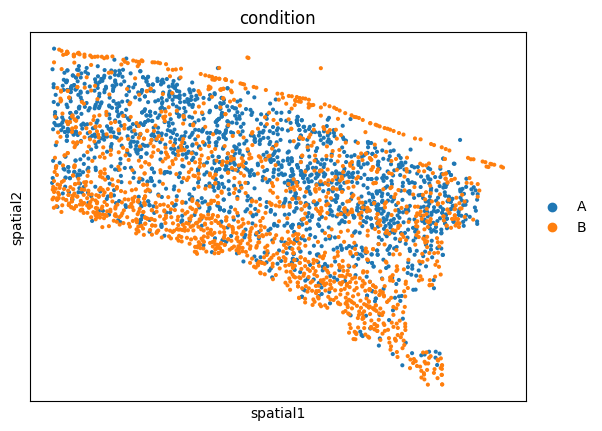

In [14]:
# split into two groups based on indices
adata.obs['condition'] = ['A' if i < round(adata.shape[0]/2) else 'B' for i in range(adata.shape[0])]

# plot conditions
sc.pl.embedding(adata, 'spatial', color='condition')

In [15]:
# multiple imputation hypothesis testing

tissue.downstream.multiple_imputation_testing(adata, "spage_predicted_expression",
                                              calib_genes=adata.var_names,
                                              condition='condition',
                                              group1 = "A", # use None to compute for all conditions, condition vs all
                                              group2 = "B", # use None to compute for group1 vs all
                                              n_imputations=10)

# extract statistics for target_gene
print("t-statistic = "+str(round(adata.uns['spage_A_B_tstat'][target_gene].values[0],5)))
print("P = "+str(round(adata.uns['spage_A_B_pvalue'][target_gene].values[0],5)))

t-statistic = -3.47963
P = 0.00085


### TISSUE Weighted PCA

In [16]:
# weighted PCA

tissue.downstream.weighted_PCA(adata, "spage", pca_method="wpca", weighting="inverse_pi_width",
                               replace_inf="max", binarize=0.2, binarize_ratio=10,
                               n_components=15)

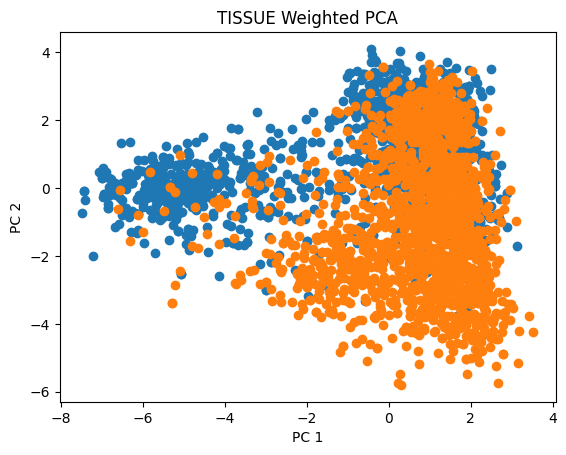

In [17]:
# make PC plot

X_pc = adata.obsm['spage_predicted_expression_PC15_']

plt.title("TISSUE Weighted PCA")
plt.scatter(X_pc[adata.obs['condition']=='A',0], X_pc[adata.obs['condition']=='A',1], c="tab:blue", label="A")
plt.scatter(X_pc[adata.obs['condition']=='B',0], X_pc[adata.obs['condition']=='B',1], c="tab:orange", label="B")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### TISSUE Cell Filtering

In [18]:
# uncertainty-based cell filtering

keep_idxs = tissue.downstream.detect_uncertain_cells (adata.obsm["spage_predicted_expression"].values,
                                                      proportion=0.1,
                                                      stratification=adata.obs['condition'].values)

adata_filtered = adata[keep_idxs,:].copy()

In [19]:
adata.shape

(3405, 31)

In [20]:
adata_filtered.shape

(3063, 31)